In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/END/Ass9'
!ls

/content/drive/MyDrive/Colab Notebooks/END/Ass9
'Copy of Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation.ipynb'
 customer_support_twitter
 customer_support_twitter.zip
'Dialogue -Neural Machine Translation by Jointly Learning to Align and Translate.ipynb'
 dstc8-schema-guided-dialogue
 processed_tweets.csv
 processed_tweets.tsv
'QA-Neural Machine Translation by Jointly Learning to Align and Translate.ipynb'
'Sequence to sequence Network for English to German translation.ipynb'
'SQuAD2.0 using attention.ipynb'
 train-v2.0.json
 tut3-model.pt
 WikiQACorpus.zip


# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.

## Introduction

As a reminder, here is the general encoder-decoder model:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq1.png?raw=1)

In the previous model, our architecture was set-up in a way to reduce "information compression" by explicitly passing the context vector, $z$, to the decoder at every time-step and by passing both the context vector and embedded input word, $d(y_t)$, along with the hidden state, $s_t$, to the linear layer, $f$, to make a prediction.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)

Even though we have reduced some of this compression, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. 

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the session.



## Preparing Data

We use [The Stanford Question Answering Dataset (SQuAD)](https://rajpurkar.github.io/SQuAD-explorer/) that has the follow format

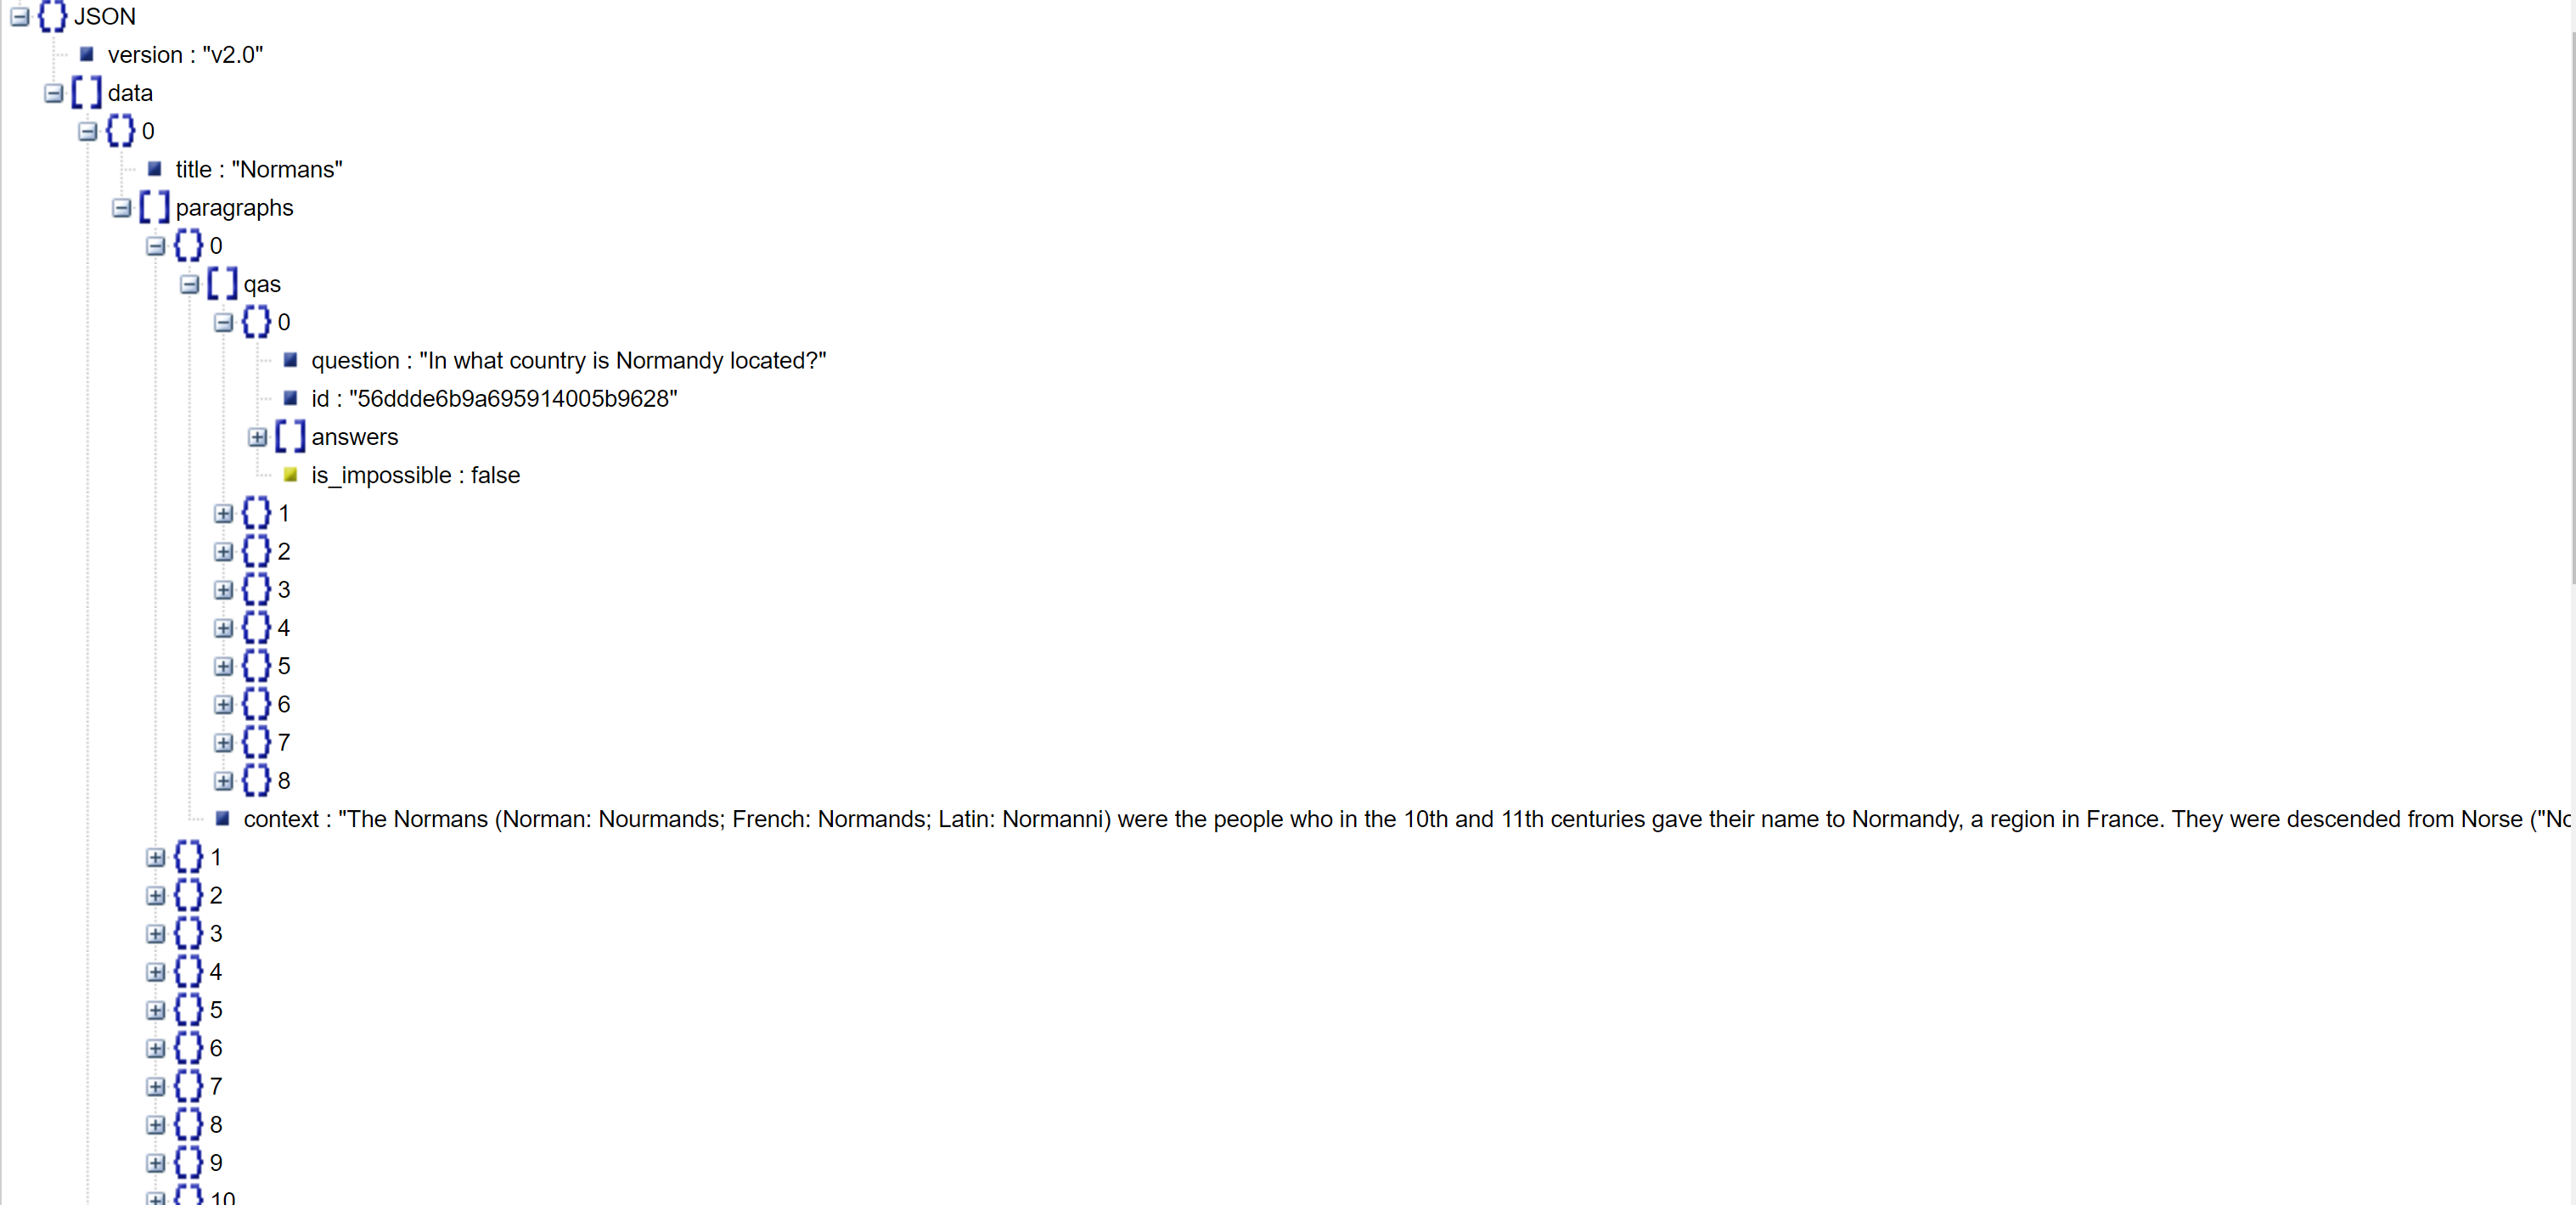

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext import data 
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time
import urllib.request, json 

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Fetch the train and validation dataset

In [5]:
with urllib.request.urlopen("https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json") as url:
    squad_data = json.loads(url.read().decode())['data']

with urllib.request.urlopen("https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json") as url:
    val_data = json.loads(url.read().decode())['data']

In [6]:
squad_data[0]

{'paragraphs': [{'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
   'qas': [{'answers': [{'answer_start': 269, 'text': 'in the late 1990s'}],
     'id': '56be85543aeaaa14008c9063',
     'is_impossible': False,
     'question': 'When did Beyonce start becoming popular?'},
    {'answers': [{'answer_start': 207, 'text': 'singing and danc

In [7]:
squad_data[0]['paragraphs'][0]['qas'][0]['answers']

[{'answer_start': 269, 'text': 'in the late 1990s'}]

Format the fetched data to create a simple list with a list of context + question and answer. Append question to context, separated by '\<sep\>' and create context-question and answer pairs

In [8]:
import random

qa_pairs_list=[]
qa_pairs_list_val=[]
def createQAlist(data, pair_list):
  for article in data: 
    for para in article['paragraphs']:
      context = para['context']
      # for each question associated with the context, create q and a list and append to 'qa_pairs_list'
      for qas in para['qas']:
        contextQuestion = context + ' <sep> ' + qas['question']
        if qas['is_impossible']:
          answer = 'is impossible'
        else:
          answer = qas['answers'][random.randint(0, len(qas['answers'])-1)]['text']
        pair_list.append([contextQuestion, answer])


createQAlist(squad_data, qa_pairs_list)
createQAlist(val_data, qa_pairs_list_val)

print(len(qa_pairs_list))
print(len(qa_pairs_list_val))

130319
11873


Create fields

In [9]:
Question = Field(sequential = True,
                 tokenize = 'spacy',
                 init_token = '<sos>',
                 eos_token = '<eos>',
                 lower = True)

In [10]:
fields = [('ContextQuestion', Question),('Answer', Question)]
fields

[('ContextQuestion', <torchtext.data.field.Field at 0x7fd369ea3ef0>),
 ('Answer', <torchtext.data.field.Field at 0x7fd369ea3ef0>)]

In [11]:
# !pip install google-trans-new

In [12]:
import random
# import google_trans_new
# from google_trans_new import google_translator
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

def get_synonyms(word):
  syns = wordnet.synsets(word) 
  return syns[0].lemmas()[0].name() if syns else word
  

def random_insertion(sentence, n=2): 
    words = sentence
    if len(words)<2:
      return words
    for _ in range(n):
        new_synonym = get_synonyms(random.choice(words))
        sentence.insert(random.randrange(len(sentence)+1), new_synonym) 
    return sentence

def random_deletion(words, p=0.5): 
    if len(words) <2: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return remaining

def random_swap(sentence, n=3): 
    length = range(len(sentence)) 
    if len(sentence) <2:
      return sentence
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

def google_trans(sentence):
    translator = google_translator()
    # sentence = ['The dog slept on the rug']

    available_langs = list(google_trans_new.LANGUAGES.keys()) 

    trans_lang = random.choice(available_langs) 
    # print(f"Translating to {google_trans_new.LANGUAGES[trans_lang]}")
    translations = translator.translate(sentence,lang_tgt=trans_lang, lang_src='en' )[2:-3]
    # print(translations)

    translations_en_random = translator.translate(translations, lang_src=trans_lang, lang_tgt='en') 
    # print('translate',translations_en_random)
    return translations_en_random if len(translations_en_random) else sentence

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
import copy

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stopwords = stopwords.words("english")

def remove_stopwords(word_list):
  return [word for word in word_list if word not in stopwords]

augment={'random_insert':True, 'random_delete':True, 'random_swap':True, 'google_translate':False}

def doAugment(aug_dict, data_to_augment):
    sentence = copy.copy(data_to_augment)
    if aug_dict['random_insert']:
      if random.random() > 0.8:
        return random_insertion(sentence)
    if aug_dict['random_delete']:
      if random.random() > 0.8:
        return random_deletion(sentence)
    if aug_dict['random_swap']: 
      if random.random() > 0.8:
        return random_swap(sentence)
    if aug_dict['google_translate']: 
      if random.random() > 0.8:
        return google_trans(sentence)
    return sentence

# def createAugmentedDataset():
#   dataset_train = []
#   dataset_val = []
#   for i in qa_pairs_list:
#       text = i[0]
#       label = i[1]
#       curr = data.Example.fromlist([text, label], fields)
#       input_without_stopwords = remove_stopwords(curr.ContextQuestion)
#       out_without_stopwords = remove_stopwords(curr.Answer)
#       if not len(input_without_stopwords) or not len(out_without_stopwords):
#         continue
#       # dataset_train.append(data.Example.fromlist([without_stopwords, label], fields))
#       text = doAugment(augment,input_without_stopwords)
#       label = doAugment(augment,out_without_stopwords)
#       dataset_train.append(data.Example.fromlist([text, label], fields))
  
#   dataset_val = [data.Example.fromlist([i[0],i[1]], fields) for i in qa_pairs_list_val] 

#   return data.Dataset(dataset_train, fields), data.Dataset(dataset_val, fields)

# train, valid = createAugmentedDataset()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# example = [data.Example.fromlist([ex[0], ex[1]], fields) for ex in qa_pairs_list]

# qaDataset = data.Dataset(example, fields)

In [15]:
# vars(qaDataset[0])

In [16]:
train = [data.Example.fromlist([ex[0], ex[1]], fields) for ex in qa_pairs_list]
train = data.Dataset(train, fields)


valid = [data.Example.fromlist([ex[0], ex[1]], fields) for ex in qa_pairs_list_val]
valid = data.Dataset(valid, fields)


Create test set from train sets

In [17]:
(train, test) = train.split(split_ratio=[0.90, 0.10], random_state=random.seed(SEED))

In [18]:
(len(train), len(valid), len(test))

(117287, 11873, 13032)

In [19]:
for example in train.examples:
    example.ContextQuestion = remove_stopwords(example.ContextQuestion)
    example.Answer = remove_stopwords(example.Answer)
    example.ContextQuestion = doAugment(augment,example.ContextQuestion)
    example.Answer = doAugment(augment,example.Answer)
  

In [20]:
# vars(train[31])

In [21]:
# from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')
# stopwords = stopwords.words("english")

# def remove_stopwords(word_list):
#   return [word for word in word_list if word not in stopwords]


# len(stopwords)

In [22]:
# for eg in train:
#   eg.ContextQuestion = remove_stopwords(eg.ContextQuestion)
#   eg.Answer = remove_stopwords(eg.Answer)

Build the vocabulary.

In [23]:
MAX_VOCAB_SIZE = 30000
Question.build_vocab(train,
                     max_size = MAX_VOCAB_SIZE,
                     vectors="glove.6B.300d",
                     unk_init = torch.Tensor.normal_)

In [24]:
len(Question.vocab)

30004

Define the device.

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Create the iterators.

In [26]:
BATCH_SIZE = 32

train_iterator, valid_iterator,test_iterator = BucketIterator.splits((train, valid, test),
                                                                     batch_size = BATCH_SIZE,
                                                                     sort_key = lambda x: len(x.ContextQuestion),
                                                                     sort_within_batch=True,
                                                                     device = device)

In [27]:
# !tar -xvf 'ubuntu_dataset.tgz.aa'
# !tar -xvf 'Question_Answer_Dataset_v1.2.tar.gz'
# !unzip WikiQACorpus.zip

## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq8.png?raw=1)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq9.png?raw=1)

In [29]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [30]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [31]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this session is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [32]:
INPUT_DIM = len(Question.vocab)
OUTPUT_DIM = len(Question.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.3
DEC_DROPOUT = 0.3

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [33]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(30004, 300)
    (rnn): GRU(300, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(30004, 300)
    (rnn): GRU(812, 256)
    (fc_out): Linear(in_features=1068, out_features=30004, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 52,083,972 trainable parameters


We create an optimizer.

In [35]:
optimizer = optim.Adam(model.parameters(), weight_decay=0.01)

We initialize the loss function.

In [36]:
QUESTION_PAD_IDX = Question.vocab.stoi[Question.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = QUESTION_PAD_IDX)

We then create the training loop...

In [37]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.ContextQuestion
        trg = batch.Answer
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [38]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.ContextQuestion
            trg = batch.Answer

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Finally, define a timing function.

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [40]:
N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'QA-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 9m 20s
	Train Loss: 5.788 | Train PPL: 326.289
	 Val. Loss: 4.758 |  Val. PPL: 116.482
Epoch: 02 | Time: 9m 22s
	Train Loss: 5.746 | Train PPL: 313.005
	 Val. Loss: 4.813 |  Val. PPL: 123.104
Epoch: 03 | Time: 9m 23s
	Train Loss: 5.741 | Train PPL: 311.431
	 Val. Loss: 4.833 |  Val. PPL: 125.632
Epoch: 04 | Time: 9m 22s
	Train Loss: 5.743 | Train PPL: 312.109
	 Val. Loss: 4.835 |  Val. PPL: 125.833
Epoch: 05 | Time: 9m 20s
	Train Loss: 5.736 | Train PPL: 309.967
	 Val. Loss: 4.718 |  Val. PPL: 111.932


Finally, we test the model on the test set using these "best" parameters.

In [41]:
model.load_state_dict(torch.load('QA-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.428 | Test PPL: 227.623 |


We've improved on the previous model, but this came at the cost of doubling the training time.
